In [1]:
!pip install roboflow
!pip install pycocotools
!pip install torch torchvision

from roboflow import Roboflow
rf = Roboflow(api_key="ihYIM7BFL7rugXS2qI8E")
project = rf.workspace("balasai").project("ships-1a6cr")
dataset = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [2]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json") 
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/workspaces/transformers/ships-2/train', processor=processor)
val_dataset = CocoDetection(img_folder='/workspaces/transformers/ships-2/valid', processor=processor, train=False)

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.


loading annotations into memory...
Done (t=0.05s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 3793
Number of validation examples: 311


Image n°2544


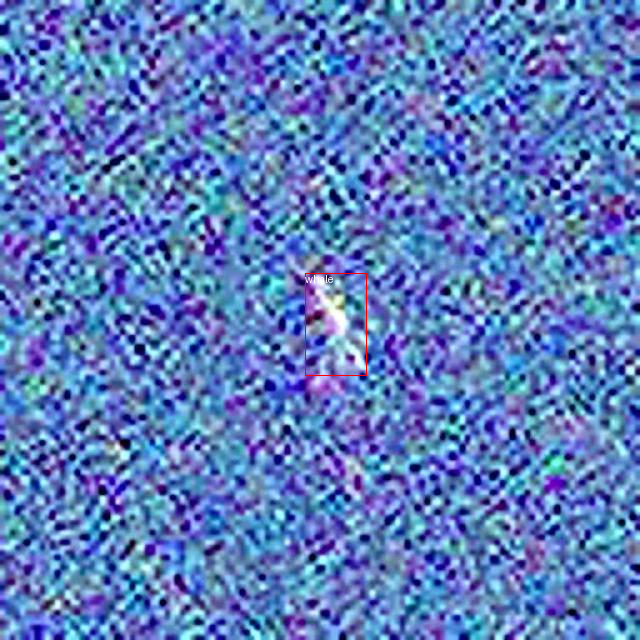

In [5]:
import numpy as np
import os
from PIL import Image, ImageDraw

# based on https://github.com/woctezuma/finetune-detr/blob/master/finetune_detr.ipynb
image_ids = train_dataset.coco.getImgIds()
# let's pick a random image
image_id = image_ids[np.random.randint(0, len(image_ids))]
print('Image n°{}'.format(image_id))
image = train_dataset.coco.loadImgs(image_id)[0]
image = Image.open(os.path.join('/workspaces/transformers/ships-2/train', image['file_name']))

annotations = train_dataset.coco.imgToAnns[image_id]
draw = ImageDraw.Draw(image, "RGBA")

cats = train_dataset.coco.cats
id2label = {k: v['name'] for k,v in cats.items()}

for annotation in annotations:
  box = annotation['bbox']
  class_idx = annotation['category_id']
  x,y,w,h = tuple(box)
  draw.rectangle((x,y,x+w,y+h), outline='red', width=1)
  draw.text((x, y), id2label[class_idx], fill='white')

image

In [6]:
from torch.utils.data import DataLoader

def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True,num_workers=4,)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=4,num_workers=4,)
batch = next(iter(train_dataloader))

This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be 

RuntimeError: DataLoader worker (pid(s) 25419, 25421, 25423, 25425) exited unexpectedly

In [ ]:
!pip install evaluate

In [ ]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection,DetrConfig
import torch
import evaluate
import transformers

from transformers import ConvNextConfig, DetrConfig, DetrForObjectDetection,AutoBackbone,EvalPrediction

module = evaluate.load("ybelkada/cocoevaluate",coco=train_dataset.coco)
class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbon
         config = DetrConfig(use_timm_backbone=False)
         self.model = DetrForObjectDetection(config)
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       print(pixel_values.shape) 
       print(self.backbone(pixel_values)) 
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)
    

       return outputs
     def on_train_epoch_end(self):
        try:
            module.compute()
        except Exception as e:
            print(e)
            pass

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)
       orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
       results = processor.post_process_object_detection(outputs, threshold=0, target_sizes=orig_target_sizes)
       try:
           module.add(prediction=results, reference=labels)
       except Exception as E:
           print(E)
       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("loss",loss,prog_bar=True,sync_dist=True)
        for i,j in loss_dict.items():
            self.log(i,j,prog_bar=True,sync_dist=True)
        # logs metrics for each training_step,
        # and the average across the epoch
        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("loss",loss,prog_bar=True,sync_dist=True)
        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [ ]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

In [ ]:
import pytorch_lightning as pl
import transformers
trainer = pl.Trainer(
    max_epochs=5,
    devices=2,  # Number of GPUs to use
    accelerator='auto',  # Distributed training strategy
    strategy = 'ddp_notebook',
)
trainer.fit(model)